In [1]:
import numpy as np
import scipy.spatial as sp
import scipy.integrate as inter
import matplotlib.pyplot as plt
import matplotlib.collections as col
import matplotlib.patches as ptch
import matplotlib.animation as ani
import os
import matplotlib.tri as mtri
from IPython.display import HTML
from numba import jit
import pickle 

import matplotlib.colors as clrs


## Build a domain with a triangulation

In [2]:
def new_neighbors(indx,ptrs,insideQ):
    good_inds=np.arange(len(insideQ))[insideQ]
    
    lbs=np.arange(sum(insideQ))
    pref=-1*np.ones(len(insideQ),dtype=int)
    pref[insideQ]=lbs

    indx_new=np.array([],dtype=int)
    ptrs_new=[0]
    pos=0
    for i in good_inds:
        pointed=indx[ptrs[i]:ptrs[i+1]]
        gpointed=insideQ[pointed]
        pointed_red=pointed[gpointed]
        new_indices=pref[pointed_red]
        indx_new=np.hstack((indx_new,new_indices))
        pos+=len(new_indices)
        ptrs_new.append(pos)
        
    return np.array(ptrs_new),indx_new


def cut_boundary(simps_raw,neigh_raw,insideQ):
    simps=[]
    simpnum=[]
    simpcount=0
    
    lbs=np.arange(sum(insideQ))
    pref=-1*np.ones(len(insideQ))
    pref[insideQ]=lbs
    
    for s in simps_raw:
        if np.product(insideQ[s]): 
            s_new=pref[s]
            simps.append(s_new)
            simpnum.append(simpcount)
            simpcount+=1
        else:
            simpnum.append(-1)

    simpnum=np.array(simpnum+[-1])
    simp_neighbors=[]
    for i in np.arange(len(simpnum)):
        if simpnum[i] !=-1:
            simp_neighbors.append(simpnum[neigh_raw[i]])
    
    return np.array(simps,dtype=int),np.array(simp_neighbors,dtype=int),simpnum

In [3]:
rs=0.5#Lattice Constant
n1=160
n2=160

z1=np.arange(-n1,n1)
z2=np.arange(-n2,n2)*np.exp(1j*np.pi/3)
zout=1j*np.add.outer(z1,z2).flatten()
xpoints=np.real(zout)#%(n1)
ypoints=np.imag(zout)

xpoints=xpoints*rs
ypoints=ypoints*rs

insideQ=xpoints**2+ypoints**2<25**2#Defines a region to be simulated

xraw=xpoints[insideQ.astype(bool)]
yraw=ypoints[insideQ.astype(bool)]

In [4]:
delaun=sp.Delaunay(np.c_[xraw,yraw])
(ptrs_raw,indx_raw)=delaun.vertex_neighbor_vertices

In [5]:
n1x=1
n1y=0
n2x=np.cos(np.pi/3)
n2y=np.sin(np.pi/3)
n3x=np.cos(2*np.pi/3)
n3y=np.sin(2*np.pi/3)

cond1=(n1x*xraw+n1y*yraw)**2<15**2
cond2=(n2x*xraw+n2y*yraw)**2<15**2
cond3=(n3x*xraw+n3y*yraw)**2<15**2

insideQ=(cond1*cond2*cond3).astype(bool)



xin=xraw[insideQ]
yin=yraw[insideQ]

In [6]:
%%time
ptrs,indx=new_neighbors(indx_raw,ptrs_raw,insideQ)
simps,simp_neighbors,simpnum=cut_boundary(delaun.simplices,delaun.neighbors,insideQ)

CPU times: user 191 ms, sys: 3.06 ms, total: 194 ms
Wall time: 194 ms


In [7]:
inside_int=insideQ.astype(int)
bnd_lap=np.zeros_like(inside_int)
for i in np.arange(len(inside_int)):
    indices=indx_raw[ptrs_raw[i]:ptrs_raw[i+1]]
    bnd_lap[i]=(sum(inside_int[indices])-len(indices)*inside_int[i])#*(len(indices)/(3*rs**2))
    
bnd_mask=bnd_lap[insideQ]<0

Building gradient functions

In [8]:
@jit(nopython=True)
def diffusion2(y):
    diff=np.zeros_like(y)
    for i in np.arange(len(xin)):
        indices=indx[ptrs[i]:ptrs[i+1]]
        diff[i]=(sum(y[indices])-len(indices)*y[i])*(len(indices)/(3*rs**2))
    return diff

In [9]:
@jit(nopython=True)
def gradient(y):
    gx=np.zeros_like(y)
    gy=np.zeros_like(y)
    for i in np.arange(len(xin)):
        indices=indx[ptrs[i]:ptrs[i+1]]
        inlen=len(indices)
        amat=np.zeros((2,2))
        df=np.zeros(2)
        for ix in indices:
            dx=xin[ix]-xin[i]
            dy=yin[ix]-yin[i]
            amat+=np.outer([dx,dy],[dx,dy])
            df+=np.array([dx,dy])*(y[ix]-y[i])
        gx[i],gy[i]=np.linalg.inv(amat)@df    
    return gx,gy

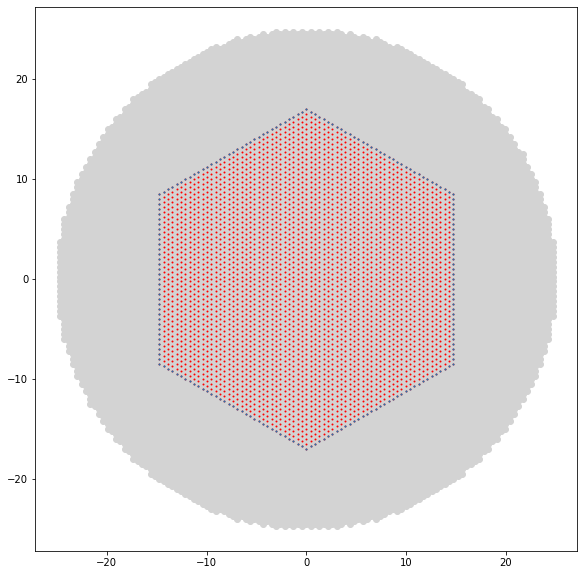

In [12]:
#visualize simulation domain
fig,ax=plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.scatter(xraw,yraw,c="lightgray",vmin=-1,vmax=1,zorder=-1)
ax.scatter(xin,yin,c="red",vmin=-1,vmax=1,s=1)
ax.scatter(xin[bnd_mask],yin[bnd_mask],zorder=2,s=1)

## Defining the equations of motion

In [13]:
profile=np.exp(- ((xin-20)**2+yin**2)/(2*15)) #the spatial profile of the external drive

omega=0.1
amp=1


@jit(nopython=True)
def drive(t):#defines the external drive applied to the membane

    drv=amp*np.cos(omega*t)*profile
    
    Nsites=len(drv)
    
    drv_long=np.zeros(3*Nsites)
    for i in np.arange(Nsites):
        drv_long[i+Nsites]=drv[i]
    
    return drv_long

k1=1.0#-1.0
k2=2.0
mu2=0.05

@jit(nopython=True)
def eom(y): #the equations of motion
    
    idx1=int(len(y)/3)
    w=y[:idx1]
    phix=y[idx1:2*idx1]
    phiy=y[2*idx1:]
    
    phix_x,phix_y=gradient(phix)
    phiy_x,phiy_y=gradient(phiy)
    phix_lap=diffusion2(phix)
    phiy_lap=diffusion2(phiy)

    w_x,w_y=gradient(w)
    w_lap=diffusion2(w)
    
    w_dot=mu2*(w_lap+phix_x+phiy_y)+k2*(phiy_x-phix_y)
    phix_dot=-mu2*(w_x+phix)+k1*phiy_lap-k2*w_y-k2*phiy
    phiy_dot=-mu2*(w_y+phiy)-k1*phix_lap+k2*w_x+k2*phix
    
    tot_dot=np.zeros(3*idx1)
    for i in np.arange(idx1):
        tot_dot[i]=w_dot[i]
        tot_dot[i+idx1]=phix_dot[i]
        tot_dot[i+2*idx1]=phiy_dot[i]
    
    return tot_dot

In [14]:
long_mask=np.hstack([bnd_mask,bnd_mask,bnd_mask])

@jit(nopython=True)
def rhs(t,y):
    em=eom(y)
    fext=drive(t)
    ftot=em+fext
    ftot[long_mask]=0
    return ftot

## Preform the simulation 

In [18]:
#initial condition
y0=np.zeros(len(xin)*3)

In [19]:
%%time
#the actual simulation. For tfinal=300, this will take about 2 hours
printsteps=10#200
tfinal=1#300
testsol2=inter.solve_ivp(rhs,(0,tfinal),y0,t_eval=np.linspace(0,tfinal,printsteps)) 

CPU times: user 1min 39s, sys: 29.3 s, total: 2min 8s
Wall time: 13.4 s


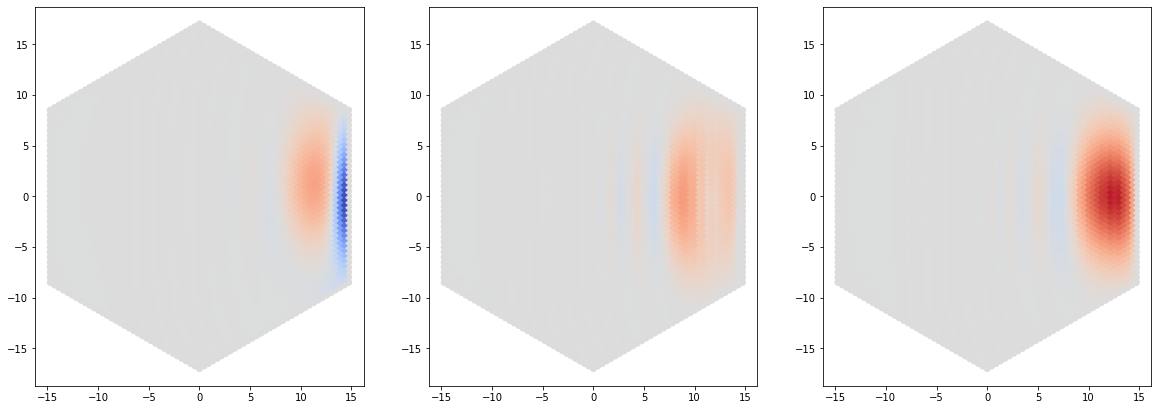

In [20]:
#visualize the solution
fig,(ax1,ax2,ax3)=plt.subplots(figsize=(20,10),ncols=3,nrows=1)

for ax in [ax1,ax2,ax3]:
    ax.set_aspect('equal')

tindex=-1
tslice=testsol2["y"][:,tindex]
wsol=tslice[:len(xin)]
pxsol=tslice[len(xin):2*len(xin)]
pysol=tslice[2*len(xin):]

wmax=np.max(np.abs(testsol2["y"][:len(xin),:]))
pxmax=np.max(np.abs(testsol2["y"][len(xin):2*len(xin),:]))
pymax=np.max(np.abs(testsol2["y"][2*len(xin):,:]))

wplot=ax1.scatter(xin,yin,zorder=2,c=wsol,cmap="coolwarm",vmin=-wmax,vmax=wmax)
phixplot=ax2.scatter(xin,yin,zorder=2,c=pxsol,cmap="coolwarm",vmin=-pxmax,vmax=pxmax)
phiyplot=ax3.scatter(xin,yin,zorder=2,c=pysol,cmap="coolwarm",vmin=-pymax,vmax=pymax)

### Saving solutions

In [21]:
data_dictionary={
    "xin": xin,
    "yin": yin,
    "simps": simps,
    "ptrs": ptrs,
    "indx": indx,
    "simp_neighbors": simp_neighbors,
    "simpnum": simpnum,
    "profile": profile,
    "omega": omega, 
    "k1": k1,
    "k2": k2,
    "mu2": mu2,
    "bndidx": np.arange(len(xin))[bnd_mask],
    "run_name": "hexagon_example_run",
    "directory": "/Users/colinscheibner/Documents/Research/Membranes/simulations/data/"
}

In [22]:
def savedata(datadict, simdata):
    foldername="{}{}_k1_{}_k2_{}_mu2_{}/".format(datadict["directory"],datadict["run_name"],datadict["k1"],datadict["k2"],datadict["mu2"],datadict["omega"])
    if not os.path.exists(foldername):
        os.mkdir(foldername)
        with open(foldername+"simdata.pkl","wb") as f:
            pickle.dump(simdata,f)
        with open(foldername+"datadict.pkl","wb") as f:
            pickle.dump(datadict,f)
        print(f"saved to folder "+foldername)
        
    else: print("path exists")
    

In [23]:
savedata(data_dictionary,testsol2)

saved to folder /Users/colinscheibner/Documents/Research/Membranes/simulations/data/hexagon_example_run_k1_1.0_k2_2.0_mu2_0.05/
